In [0]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    in_google_colab = True
    %tensorflow_version 1.x
except:
    in_google_colab = False

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('Tensorflow version is {}'.format(tf.__version__))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 1.x selected.
Found GPU at: /device:GPU:0
Tensorflow version is 1.15.2


In [0]:
if in_google_colab:
    print("Currently in google colab, unpacking the files")
    !rm -r /content/mask_rcnn_envir
    !unzip /content/drive/'My Drive'/mask_rcnn_envir.zip  -d /content
    %cd mask_rcnn_envir/
else:
    print("Not in google colab")

Currently in google colab, unpacking the files
rm: cannot remove '/content/mask_rcnn_envir': No such file or directory
Archive:  /content/drive/My Drive/mask_rcnn_envir.zip
   creating: /content/mask_rcnn_envir/.ipynb_checkpoints/
  inflating: /content/mask_rcnn_envir/.ipynb_checkpoints/CA1 v1 Colab Version (edited, to 1 script, v2)-checkpoint.ipynb  
   creating: /content/mask_rcnn_envir/__pycache__/
  inflating: /content/mask_rcnn_envir/__pycache__/mask_rcnn_v2.cpython-36.pyc  
   creating: /content/mask_rcnn_envir/annotations/
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json  
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json  
  inflating: /content/mask_rcnn_envir/CA1 v1 - combined.ipynb  
  inflating: /content/mask_rcnn_envir/CA1 v1 Colab Version (edited, to 1 script, v2).ipynb  
  inflating: /content/mask_rcnn_envir/final_segmentation_metadata.csv  
  inflating: /content/mask_rcnn_envir/mask_rcnn

In [0]:
from mask_rcnn_v2 import Config, MaskRCNN, buildMASKRCNN, Dataset, CocoLikeDataset, display_top_masks, display_instances
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import json
from PIL import Image, ImageDraw
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model

from os import listdir
from xml.etree import ElementTree

from pycocotools import mask as maskUtils

from imgaug import augmenters as iaa

import pandas as pd

%matplotlib inline

Using TensorFlow backend.


In [0]:
class myMaskRCNNConfig(Config):
    NAME = 'MaskRCNN_config'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 3 + 1
    #self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES
    
    STEPS_PER_EPOCH = 131

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512     

    BACKBONE = 'resnet50'             

In [0]:
config = myMaskRCNNConfig()

In [0]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json', '/content/mask_rcnn_envir/openimagev5tococo_train2020')
dataset_train.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json', '/content/mask_rcnn_envir/openimagev5tococo_val2020')
dataset_val.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_train.class_names

['BG', 'Dress', 'Suit', 'Jeans']

In [0]:
dataset_val.class_names

['BG', 'Dress', 'Suit', 'Jeans']

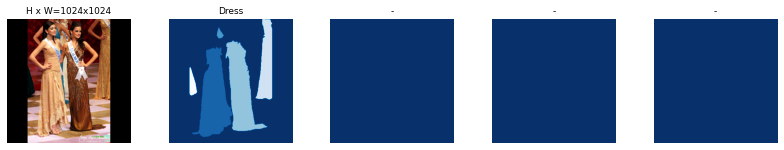

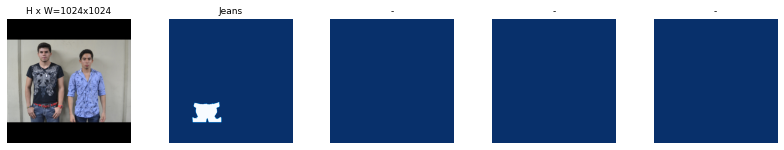

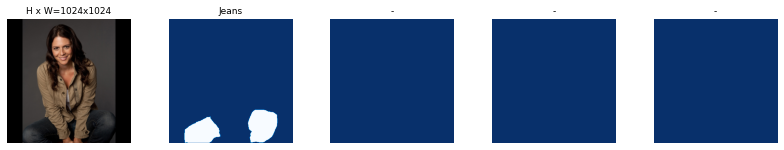

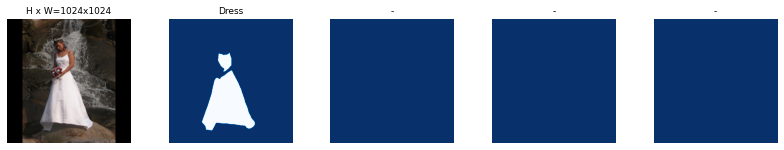

In [0]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names)

TRANSFER LEARNING ON MASK RCNN

In [0]:
model = buildMASKRCNN(config=config, model_dir="./")

#exclude the last few layers from training for ResNet101
#exclude the last layers is to match the number of classes in the new dataset
model.load_weights('./mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=40, 
            learning_rate=config.LEARNING_RATE, 
            layers='heads'
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: ./maskrcnn_config20200405T1411/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/40
131/131 [==============================] - 58s 446ms/step - loss: 21.0292 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 19.1747 - mrcnn_class_loss: 0.4221 - mrcnn_bbox_loss: 0.7976 - mrcnn_mask_loss: 0.5597 - val_loss: 13.8521 - val_rpn_class_loss: 0.0516 - val_rpn_bbox_loss: 12.3364 - val_mrcnn_class_loss: 0.1702 - val_mrcnn_bbox_loss: 0.7034 - val_mrcnn_mask_loss: 0.5906

Epoch 2/40
131/131 [==============================] - 28s 211ms/step - loss: 12.7452 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 11.3393 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.6098 - mrcnn_mask_loss: 0.4989 - val_loss: 16.4024 - val_rpn_class_loss: 0.0383 - val_rpn_bbox_loss: 14.9606 - val_mrcnn_class_loss: 0.1736 - val_mrcnn_bbox_loss: 0.6364 - val_mrcnn_mask_loss: 0.5935
Epoch 3/40
131/131 [==============================] - 28s 213ms/step - loss: 28.8626 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 27.4227 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.5996 - mrcnn_mask_loss: 0.4470 - val_loss: 14.26

In [0]:
history = model.keras_model.history.history

Fine Tune ALL layers

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=60, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            )


Starting at epoch 40. LR=0.001

Checkpoint Path: ./maskrcnn_config20200405T1411/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 41/60
131/131 [==============================] - 70s 531ms/step - loss: 6.3456 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 5.4721 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.3125 - val_loss: 11.5799 - val_rpn_class_loss: 0.0327 - val_rpn_bbox_loss: 10.5340 - val_mrcnn_class_loss: 0.1234 - val_mrcnn_bbox_loss: 0.4622 - val_mrcnn_mask_loss: 0.4274
Epoch 42/60
131/131 [==============================] - 36s 274ms/step - loss: 5.9215 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 5.1144 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.2859 - mrcnn_mask_loss: 0.3152 - val_loss: 13.9564 - val_rpn_class_loss: 0.0371 - val_rpn_bbox_loss: 12.9104 - val_mrcnn_class_loss: 0.1540 - val_mrcnn_bbox_loss: 0.4305 - val_mrcnn_mask_loss: 0.4244
Epoch 43/60
131/131 [==============================] - 36s 276ms/step - loss: 12.7232 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 11.7397 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.3235 - val_loss: 11.7071 -

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
import pandas as pd
epochs = range(1, len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1   13.852149            0.051594  ...         0.797610         0.559654
2   16.402426            0.038316  ...         0.609771         0.498858
3   14.268803            0.038333  ...         0.599563         0.446964
4   13.035670            0.039582  ...         0.552898         0.469608
5   13.012875            0.037055  ...         0.529299         0.416322
6   13.347441            0.035049  ...         0.492890         0.386130
7   13.582313            0.034501  ...         0.455499         0.433581
8   15.224680            0.033836  ...         0.443892         0.402355
9   12.874979            0.032211  ...         0.445366         0.397978
10  11.770604            0.033275  ...         0.402808         0.349354
11  12.303361            0.032230  ...         0.385323         0.369738
12  14.057019            0.028720  ...         0.413763         0.373430
13  10.854124            0.028378  ...         0.411595         0.365693
14  18.059055            0.035492  ...         0.394048         0.371949
15  13.311928            0.031270  ...         0.425823         0.369734
16  12.232042            0.029933  ...         0.438419         0.382124
17  12.190249            0.031815  ...         0.394853         0.389558
18  15.129113            0.032709  ...         0.368120         0.344157
19  11.987664            0.026895  ...         0.337272         0.355921
20  15.148781            0.030543  ...         0.306116         0.314956
21  10.770089            0.024539  ...         0.318095         0.330676
22  10.761082            0.034135  ...         0.356483         0.353053
23  11.214827            0.027917  ...         0.333499         0.323589
24  11.272070            0.027329  ...         0.332277         0.345300
25  11.433445            0.033398  ...         0.305021         0.341920
26  13.812987            0.028024  ...         0.300033         0.324152
27  11.133628            0.024665  ...         0.286791         0.335308
28  11.259755            0.027759  ...         0.290904         0.327452
29  11.302323            0.028921  ...         0.299985         0.331453
30  12.647798            0.029576  ...         0.305296         0.306825
31  10.879400            0.030407  ...         0.299601         0.313880
32  11.074968            0.027699  ...         0.291257         0.317339
33  11.376982            0.030145  ...         0.289858         0.298039
34  11.051110            0.029076  ...         0.264936         0.286328
35   8.730531            0.027250  ...         0.266863         0.312704
36  10.050374            0.030890  ...         0.263691         0.294702
37  13.101252            0.027045  ...         0.242615         0.281509
38  10.910993            0.026798  ...         0.242263         0.299072
39  10.459322            0.025844  ...         0.290709         0.322682
40  13.316387            0.032232  ...         0.285161         0.318428
41  11.579863            0.032697  ...         0.282957         0.312480
42  13.956438            0.037129  ...         0.285933         0.315234
43  11.707113            0.026689  ...         0.318230         0.323500
44  10.535145            0.027308  ...         0.303095         0.302799
45  11.770249            0.027091  ...         0.276964         0.319472
46  11.257998            0.024311  ...         0.261743         0.271045
47  11.393499            0.027247  ...         0.262824         0.315942
48  10.095290            0.023452  ...         0.246225         0.283759
49   9.216897            0.026899  ...         0.256049         0.299610
50  10.393982            0.025698  ...         0.228221         0.287866
51   9.984366            0.027879  ...         0.219652         0.269011
52  10.270531            0.022426  ...         0.256995         0.293114
53  10.330535            0.026252  ...         0.221930         0.280556
54  11.789310            0.028175  ...         0.210979        

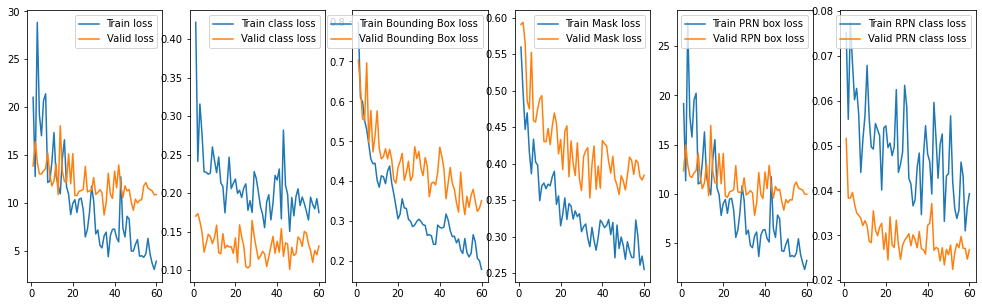

In [0]:
plt.figure(figsize=(17,5))

plt.subplot(161)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(162)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class loss")
plt.legend()
plt.subplot(163)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train Bounding Box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid Bounding Box loss")
plt.legend()
plt.subplot(164)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()
plt.subplot(165)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train PRN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(166)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class loss")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid PRN class loss")
plt.legend()


plt.show()

In [0]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 35 8.730530924797058
